# Code for reproducing results in Figure 6

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

sns.set_context("talk")
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec


from loren_frank_data_processing import (
    get_multiunit_dataframe,
    get_multiunit_dataframe2,
)

from src.load_data import load_data
from src.parameters import ANIMALS
from utils import get_steps, get_diffusion_exponent

## Section 1: plot example replay trajectory for awake and sleep

In [3]:
epoch_key = ("bon", 8, 4)
data = load_data(epoch_key)

Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules


In [4]:
# load replay result
datafolder = (
    "/home/zilong/Desktop/AdaptiveAttractorForSequences/ExpData/ThetaSweepTrajectories"
)

animal, day, epoch = epoch_key
# load the classifier results
cv_classifier_clusterless_results = xr.open_dataset(
    os.path.join(
        datafolder,
        f"{animal}_{day:02d}_{epoch:02d}_cv_classifier_clusterless_results.nc",
    )
)

# get all time slice
t = data["position_info"].index / np.timedelta64(1, "s")

In [5]:
# load multiunit times
multiunit_times = [
    get_multiunit_dataframe(tetrode_key, ANIMALS)
    for tetrode_key in data["tetrode_info"].index
]
if multiunit_times[0] is None:
    multiunit_times = [
        get_multiunit_dataframe2(tetrode_key, ANIMALS)
        for tetrode_key in data["tetrode_info"].index
    ]
# reset index in multiunit_times to seconds and replace the original multiunit_times
for i in range(len(multiunit_times)):
    indext_i = multiunit_times[i].index / np.timedelta64(1, "s")
    multiunit_times[i].index = indext_i

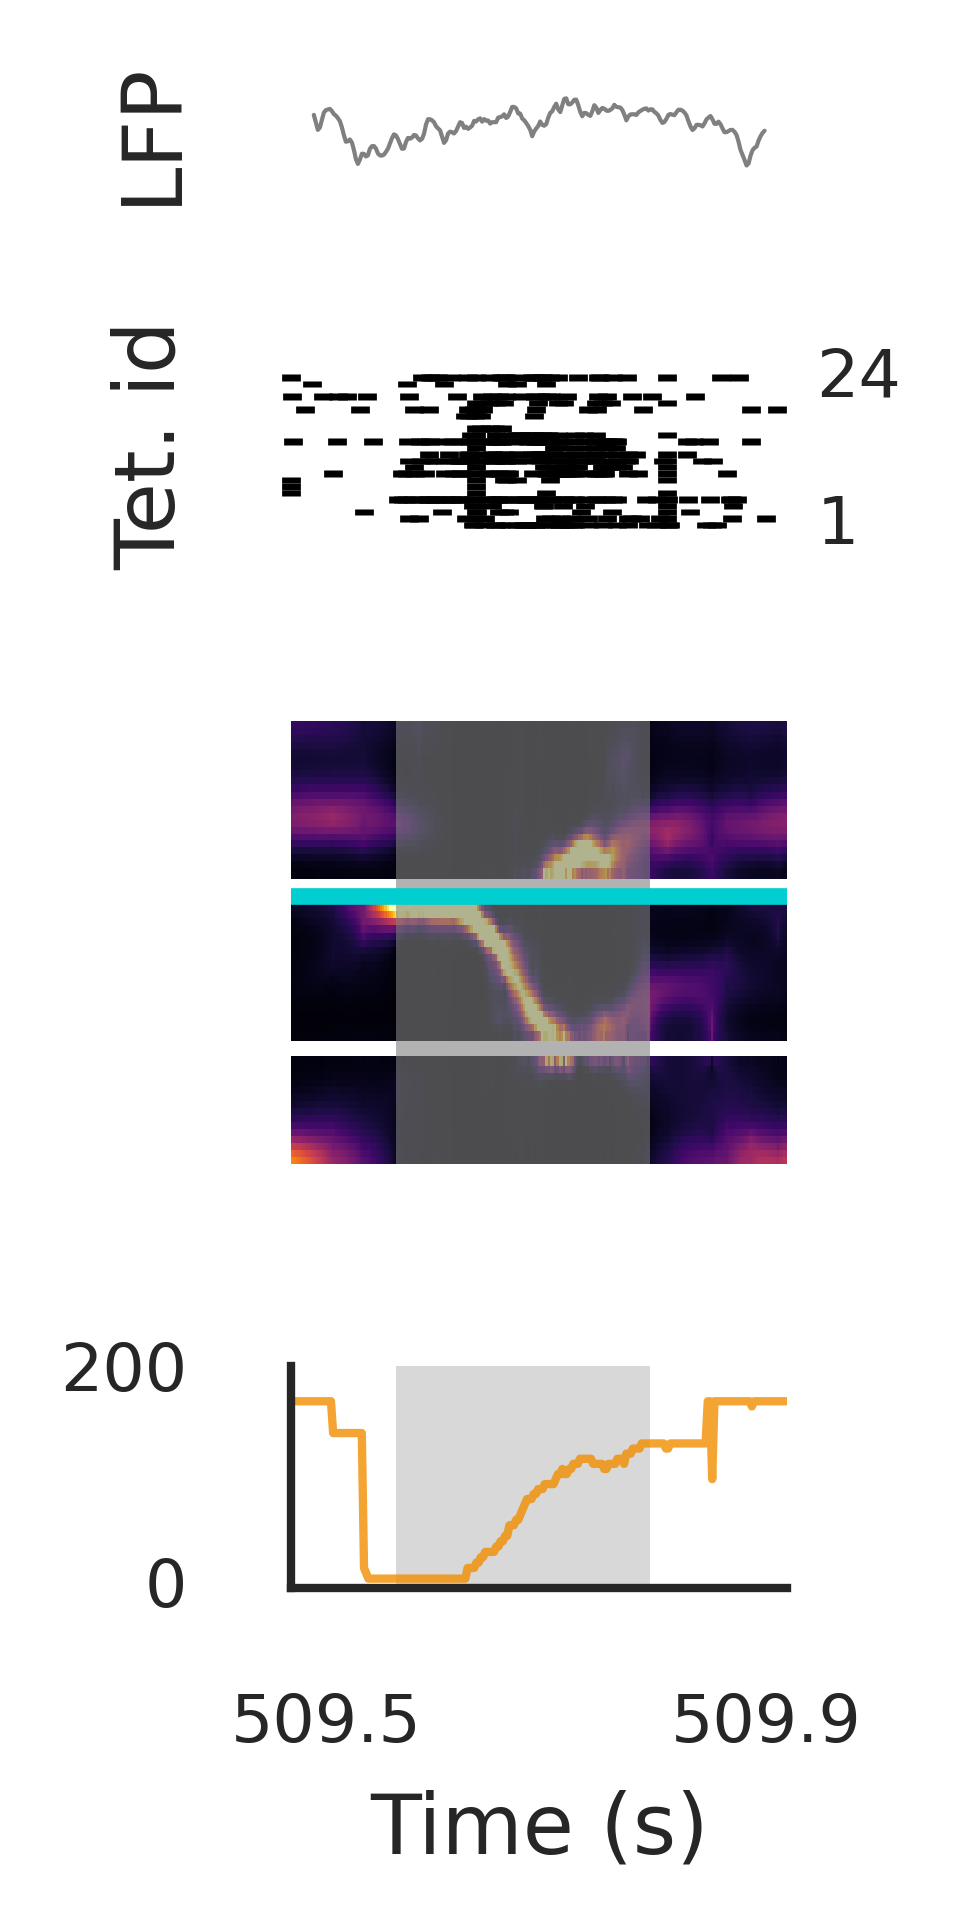

In [6]:
def plot_awake_replay_trajectory(
    time_slice_replay, t, multiunit_times, results, data, figsize=(8, 3)
):

    """
    Modified from https://github.com/edeno/replicate_kenny_analysis/blob/master/notebooks/Bond_day8_Epoch4.ipynb
    by Zilong, 30/08/2023
    plor the theta sweeps in time_slice
    Input:
        time_slice_replay: the time slice to plot. a list
        t: the time index
        results: the results from the model
        data: the data from the model
        add_zero_phase_index: whether to add the zero phase index
    Output:
    """

    cmap = plt.cm.inferno
    cmap.set_bad("white", alpha=1.0)
    labelsize = 10
    ticksize = 8
    # set background color to white
    sns.set_style("white")

    fig = plt.figure(figsize=figsize, dpi=300)

    cols = len(time_slice_replay)
    gs = gridspec.GridSpec(4, cols, height_ratios=[0.5, 1, 3, 1.5])

    for i in range(cols):

        time_slice_replay_i = time_slice_replay[i]

        ax5 = plt.subplot(gs[0, i])
        ind = 0
        lfp = (
            data["lfps"]
            .reset_index(drop=True)
            .set_index(data["lfps"].index / np.timedelta64(1, "s"))
        )

        # plot as curve, not fill
        ax5.plot(
            lfp.loc[time_slice_replay_i].index.values,
            lfp.loc[time_slice_replay_i].iloc[:, ind].values.squeeze(),
            color="grey",
            linewidth=0.5,
        )
        ax5.set_ylabel("LFP")

        # remove xticks
        ax5.set_xticks([])
        # remove y ticks
        ax5.set_yticks([])

        ax3 = plt.subplot(gs[1, i])

        n_tetrodes = len(multiunit_times)

        ax3.eventplot(
            [multiunit.loc[time_slice_replay_i].index for multiunit in multiunit_times],
            color="black",
            clip_on=False,
        )

        ax3.set_yticks((1, n_tetrodes))
        ax3.set_ylim((1, n_tetrodes))
        ax3.set_ylabel("Tet. id")
        ax3.set_xticks([])
        sns.despine(ax=ax3, offset=5)
        ax3.spines["bottom"].set_visible(False)

        # move the y ticks to right
        ax3.yaxis.tick_right()
        # remove y tick bars
        ax3.tick_params(axis="y", length=0)

        ax0 = plt.subplot(gs[2, i])
        # plot
        results["acausal_posterior"].sum("state", skipna=False).sel(
            time=time_slice_replay_i
        ).plot(
            x="time",
            y="position",
            robust=True,
            ax=ax0,
            cmap=cmap,
            vmin=0.0,
        )

        ax0.plot(
            data["position_info"]
            .reset_index()
            .set_index(t)
            .loc[time_slice_replay_i]
            .index,
            data["position_info"]
            .reset_index()
            .set_index(t)
            .loc[time_slice_replay_i]
            .linear_position,
            color="darkturquoise",
            linestyle="-",
            linewidth=2,
            alpha=1,
        )

        # remove all labels, ticks and spines in axi, as well as colorbars
        ax0.set_xlabel("")
        ax0.set_ylabel("")
        ax0.set_yticks([])
        ax0.set_xticks([])
        ax0.spines["right"].set_visible(False)
        ax0.spines["top"].set_visible(False)
        ax0.spines["left"].set_visible(False)
        ax0.spines["bottom"].set_visible(False)
        ax0.collections[0].colorbar.remove()

        # ax1
        ax1 = plt.subplot(gs[3, i])
        results.mental_distance_from_actual_position.sel(time=time_slice_replay_i).plot(
            x="time", ax=ax1, color="#F18D00", linewidth=1, alpha=0.8
        )
        # set y label as 'Offset' and x label empty
        ax1.set_ylabel("", fontsize=labelsize)
        ax1.set_xlabel("Time (s)", fontsize=labelsize)
        # set ticks off
        ax1.set_yticks([0, 200])
        # set x ticks with time_slice_replay.start and time_slice_replay.stop without scientific notation
        ax1.set_xticks(
            [
                np.round(time_slice_replay_i.start, 1),
                np.round(time_slice_replay_i.stop, 1),
            ]
        )
        # tick labels without scientific notation
        ax1.ticklabel_format(useOffset=False, style="plain")
        # set tick labels
        ax1.set_xticklabels(
            [
                np.round(time_slice_replay_i.start - t.min(), 1),
                np.round(time_slice_replay_i.stop - t.min(), 1),
            ],
            fontsize=ticksize,
        )
        # set tick font size as ticksize
        ax1.tick_params(labelsize=ticksize)

        # add ripple times to the plot as red bars on top of the LFP
        # first get the ripples time within the time slice
        for k in data["ripple_times"].index:
            # get the ripple time
            ripple_time = data["ripple_times"].iloc[k - 1]
            start_time = ripple_time.loc["start_time"] / np.timedelta64(1, "s")
            end_time = ripple_time.loc["end_time"] / np.timedelta64(1, "s")
            # if start_time and end_time are both in the time slice. then add the ripple to the plot
            # x range is start_time to end_time, y range is [0,300]
            if (
                start_time > time_slice_replay_i.start
                and end_time < time_slice_replay_i.stop
            ):
                ax0.axvspan(
                    start_time, end_time, ymin=0, ymax=1, color="grey", alpha=0.6, lw=0
                )
                ax1.axvspan(
                    start_time, end_time, ymin=0, ymax=1, color="grey", alpha=0.3, lw=0
                )
        # add back ax1 bottom and left spines
        ax1.spines["bottom"].set_visible(True)
        ax1.spines["left"].set_visible(True)
        # set axis linewidth 1.0
        ax1.spines["bottom"].set_linewidth(1.0)
        ax1.spines["left"].set_linewidth(1.0)

        ax3.set_xlim(time_slice_replay_i.start, time_slice_replay_i.stop)
        ax0.set_xlim(time_slice_replay_i.start, time_slice_replay_i.stop)
        ax1.set_xlim(time_slice_replay_i.start, time_slice_replay_i.stop)

    # set ticks and spines
    all_axes = fig.get_axes()
    for ax in all_axes:
        ax.tick_params(labelsize=ticksize)
        ax.xaxis.label.set_size(labelsize)
        ax.yaxis.label.set_size(labelsize)
        # set axes off bottom left top and right
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.yaxis.set_label_coords(-0.2, 0.5)

    ax1.spines["bottom"].set_visible(True)
    ax1.spines["left"].set_visible(True)

    plt.tight_layout()

    # save the figure to /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/
    savedir = "/home/zilong/Desktop/AdaptiveAttractorForSequences/Figures/"

    savename = "Fig6_awake_vs_sleep_awakereplayexample.pdf"
    plt.savefig(savedir + savename, dpi=300, bbox_inches="tight")


time_slice_1 = slice(t.min() + 42.35, t.min() + 42.7)
# time_slice_2 = slice(t.min() + 89.45, t.min() + 89.9)
time_slice_3 = slice(t.min() + 509.45, t.min() + 509.9)
# time_slice_4 = slice(t.min() + 662.8, t.min() + 663.2)
# time_slice_5 = slice(t.min() + 866.3, t.min() + 866.7)

# time_slice_replay = [
#     time_slice_1,
#     # time_slice_2,
#     time_slice_3,
#     # time_slice_4,
#     # time_slice_5,
# ]

time_slice_replay = [time_slice_3]

plot_awake_replay_trajectory(
    time_slice_replay,
    t,
    multiunit_times,
    cv_classifier_clusterless_results,
    data,
    figsize=(2, 3.5),
)

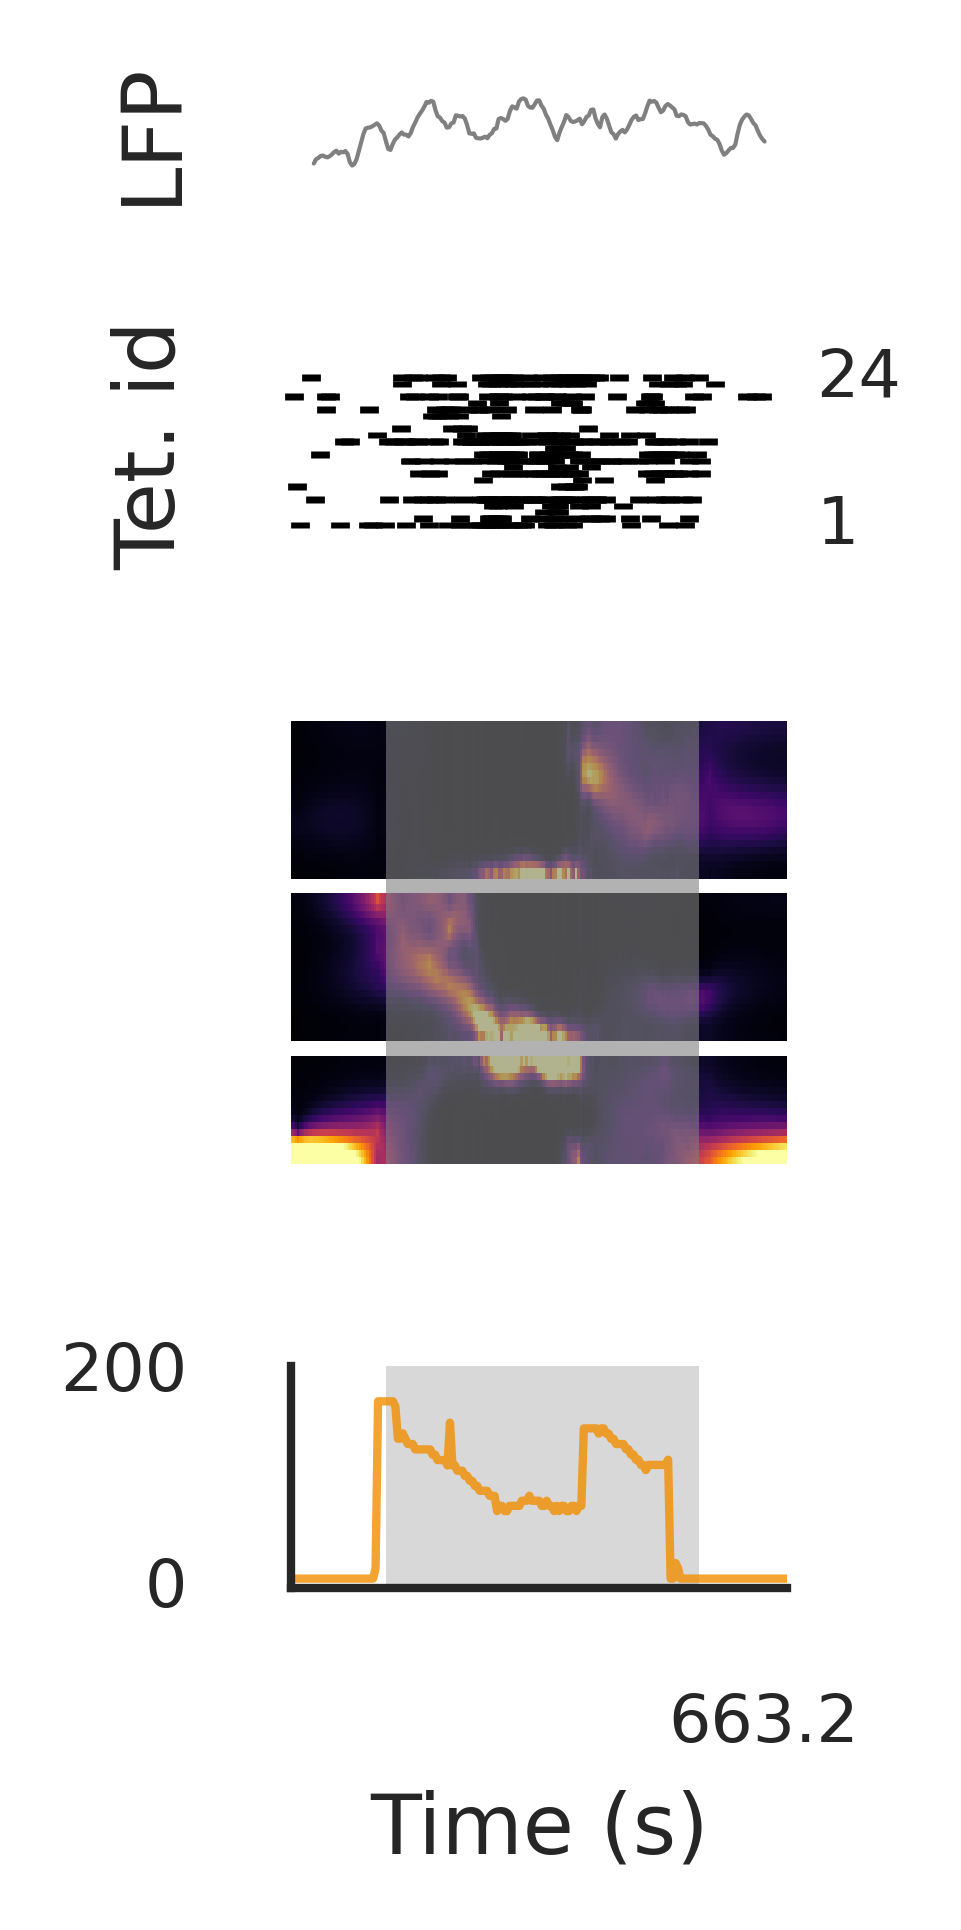

In [7]:
def plot_sleep_replay_trajectory(
    time_slice_replay, t, multiunit_times, results, data, figsize=(8, 3)
):

    """
    Modified from https://github.com/edeno/replicate_kenny_analysis/blob/master/notebooks/Bond_day8_Epoch4.ipynb
    by Zilong, 30/08/2023
    plor the theta sweeps in time_slice
    Input:
        time_slice_replay: the time slice to plot. a list
        t: the time index
        results: the results from the model
        data: the data from the model
        add_zero_phase_index: whether to add the zero phase index
    Output:
    """

    cmap = plt.cm.inferno
    cmap.set_bad("white", alpha=1.0)
    labelsize = 10
    ticksize = 8
    # set background color to white
    sns.set_style("white")

    fig = plt.figure(figsize=figsize, dpi=300)

    cols = len(time_slice_replay)
    gs = gridspec.GridSpec(4, cols, height_ratios=[0.5, 1, 3, 1.5])

    for i in range(cols):

        time_slice_replay_i = time_slice_replay[i]

        ax5 = plt.subplot(gs[0, i])
        ind = 0
        lfp = (
            data["lfps"]
            .reset_index(drop=True)
            .set_index(data["lfps"].index / np.timedelta64(1, "s"))
        )

        # plot as curve, not fill
        ax5.plot(
            lfp.loc[time_slice_replay_i].index.values,
            lfp.loc[time_slice_replay_i].iloc[:, ind].values.squeeze(),
            color="grey",
            linewidth=0.5,
        )
        ax5.set_ylabel("LFP")

        # remove xticks
        ax5.set_xticks([])
        # remove y ticks
        ax5.set_yticks([])

        ax3 = plt.subplot(gs[1, i])

        n_tetrodes = len(multiunit_times)

        ax3.eventplot(
            [multiunit.loc[time_slice_replay_i].index for multiunit in multiunit_times],
            color="black",
            clip_on=False,
        )

        ax3.set_yticks((1, n_tetrodes))
        ax3.set_ylim((1, n_tetrodes))
        ax3.set_ylabel("Tet. id")
        ax3.set_xticks([])
        sns.despine(ax=ax3, offset=5)
        ax3.spines["bottom"].set_visible(False)

        # move the y ticks to right
        ax3.yaxis.tick_right()
        # remove y tick bars
        ax3.tick_params(axis="y", length=0)

        ax0 = plt.subplot(gs[2, i])
        # plot
        results["acausal_posterior"].sum("state", skipna=False).sel(
            time=time_slice_replay_i
        ).plot(
            x="time",
            y="position",
            robust=True,
            ax=ax0,
            cmap=cmap,
            vmin=0.0,
        )

        # remove all labels, ticks and spines in axi, as well as colorbars
        ax0.set_xlabel("")
        ax0.set_ylabel("")
        ax0.set_yticks([])
        ax0.set_xticks([])
        ax0.spines["right"].set_visible(False)
        ax0.spines["top"].set_visible(False)
        ax0.spines["left"].set_visible(False)
        ax0.spines["bottom"].set_visible(False)
        ax0.collections[0].colorbar.remove()

        # ax1
        ax1 = plt.subplot(gs[3, i])
        results.mental_distance_from_actual_position.sel(time=time_slice_replay_i).plot(
            x="time", ax=ax1, color="#F18D00", linewidth=1, alpha=0.8
        )
        # set y label as 'Offset' and x label empty
        ax1.set_ylabel("", fontsize=labelsize)
        ax1.set_xlabel("Time (s)", fontsize=labelsize)
        # set ticks off
        ax1.set_yticks([0, 200])
        # set x ticks with time_slice_replay.start and time_slice_replay.stop without scientific notation
        ax1.set_xticks(
            [
                np.round(time_slice_replay_i.start, 1),
                np.round(time_slice_replay_i.stop, 1),
            ]
        )
        # tick labels without scientific notation
        ax1.ticklabel_format(useOffset=False, style="plain")
        # set tick labels
        ax1.set_xticklabels(
            [
                np.round(time_slice_replay_i.start - t.min(), 1),
                np.round(time_slice_replay_i.stop - t.min(), 1),
            ],
            fontsize=ticksize,
        )
        # set tick font size as ticksize
        ax1.tick_params(labelsize=ticksize)

        # add ripple times to the plot as red bars on top of the LFP
        # first get the ripples time within the time slice
        for k in data["ripple_times"].index:
            # get the ripple time
            ripple_time = data["ripple_times"].iloc[k - 1]
            start_time = ripple_time.loc["start_time"] / np.timedelta64(1, "s")
            end_time = ripple_time.loc["end_time"] / np.timedelta64(1, "s")
            # if start_time and end_time are both in the time slice. then add the ripple to the plot
            # x range is start_time to end_time, y range is [0,300]
            if (
                start_time > time_slice_replay_i.start
                and end_time < time_slice_replay_i.stop
            ):
                ax0.axvspan(
                    start_time, end_time, ymin=0, ymax=1, color="grey", alpha=0.6, lw=0
                )
                ax1.axvspan(
                    start_time, end_time, ymin=0, ymax=1, color="grey", alpha=0.3, lw=0
                )
        # add back ax1 bottom and left spines
        ax1.spines["bottom"].set_visible(True)
        ax1.spines["left"].set_visible(True)
        # set axis linewidth 1.0
        ax1.spines["bottom"].set_linewidth(1.0)
        ax1.spines["left"].set_linewidth(1.0)

        ax3.set_xlim(time_slice_replay_i.start, time_slice_replay_i.stop)
        ax0.set_xlim(time_slice_replay_i.start, time_slice_replay_i.stop)
        ax1.set_xlim(time_slice_replay_i.start, time_slice_replay_i.stop)

    # set ticks and spines
    all_axes = fig.get_axes()
    for ax in all_axes:
        ax.tick_params(labelsize=ticksize)
        ax.xaxis.label.set_size(labelsize)
        ax.yaxis.label.set_size(labelsize)
        # set axes off bottom left top and right
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.yaxis.set_label_coords(-0.2, 0.5)

    ax1.spines["bottom"].set_visible(True)
    ax1.spines["left"].set_visible(True)

    plt.tight_layout()

    # save the figure to /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/
    savedir = "/home/zilong/Desktop/AdaptiveAttractorForSequences/Figures/"

    savename = "Fig6_awake_vs_sleep_sleepreplayexample.pdf"
    plt.savefig(savedir + savename, dpi=300, bbox_inches="tight")


time_slice_1 = slice(t.min() + 42.35, t.min() + 42.7)
# time_slice_2 = slice(t.min() + 89.45, t.min() + 89.9)
# time_slice_3 = slice(t.min() + 509.45, t.min() + 509.9)
time_slice_4 = slice(t.min() + 662.8, t.min() + 663.2)
time_slice_5 = slice(t.min() + 866.3, t.min() + 866.7)

time_slice_replay = [time_slice_4]

plot_sleep_replay_trajectory(
    time_slice_replay,
    t,
    multiunit_times,
    cv_classifier_clusterless_results,
    data,
    figsize=(2, 3.5),
)

## Sectoin 2: plot the step size distribution for awake and sleep for one recording epoch

In [8]:
from scipy.stats import genpareto
from scipy.optimize import curve_fit

[-0.3707792  10.04583048 73.33697242] [-0.30767094  9.39701363 49.73265415]


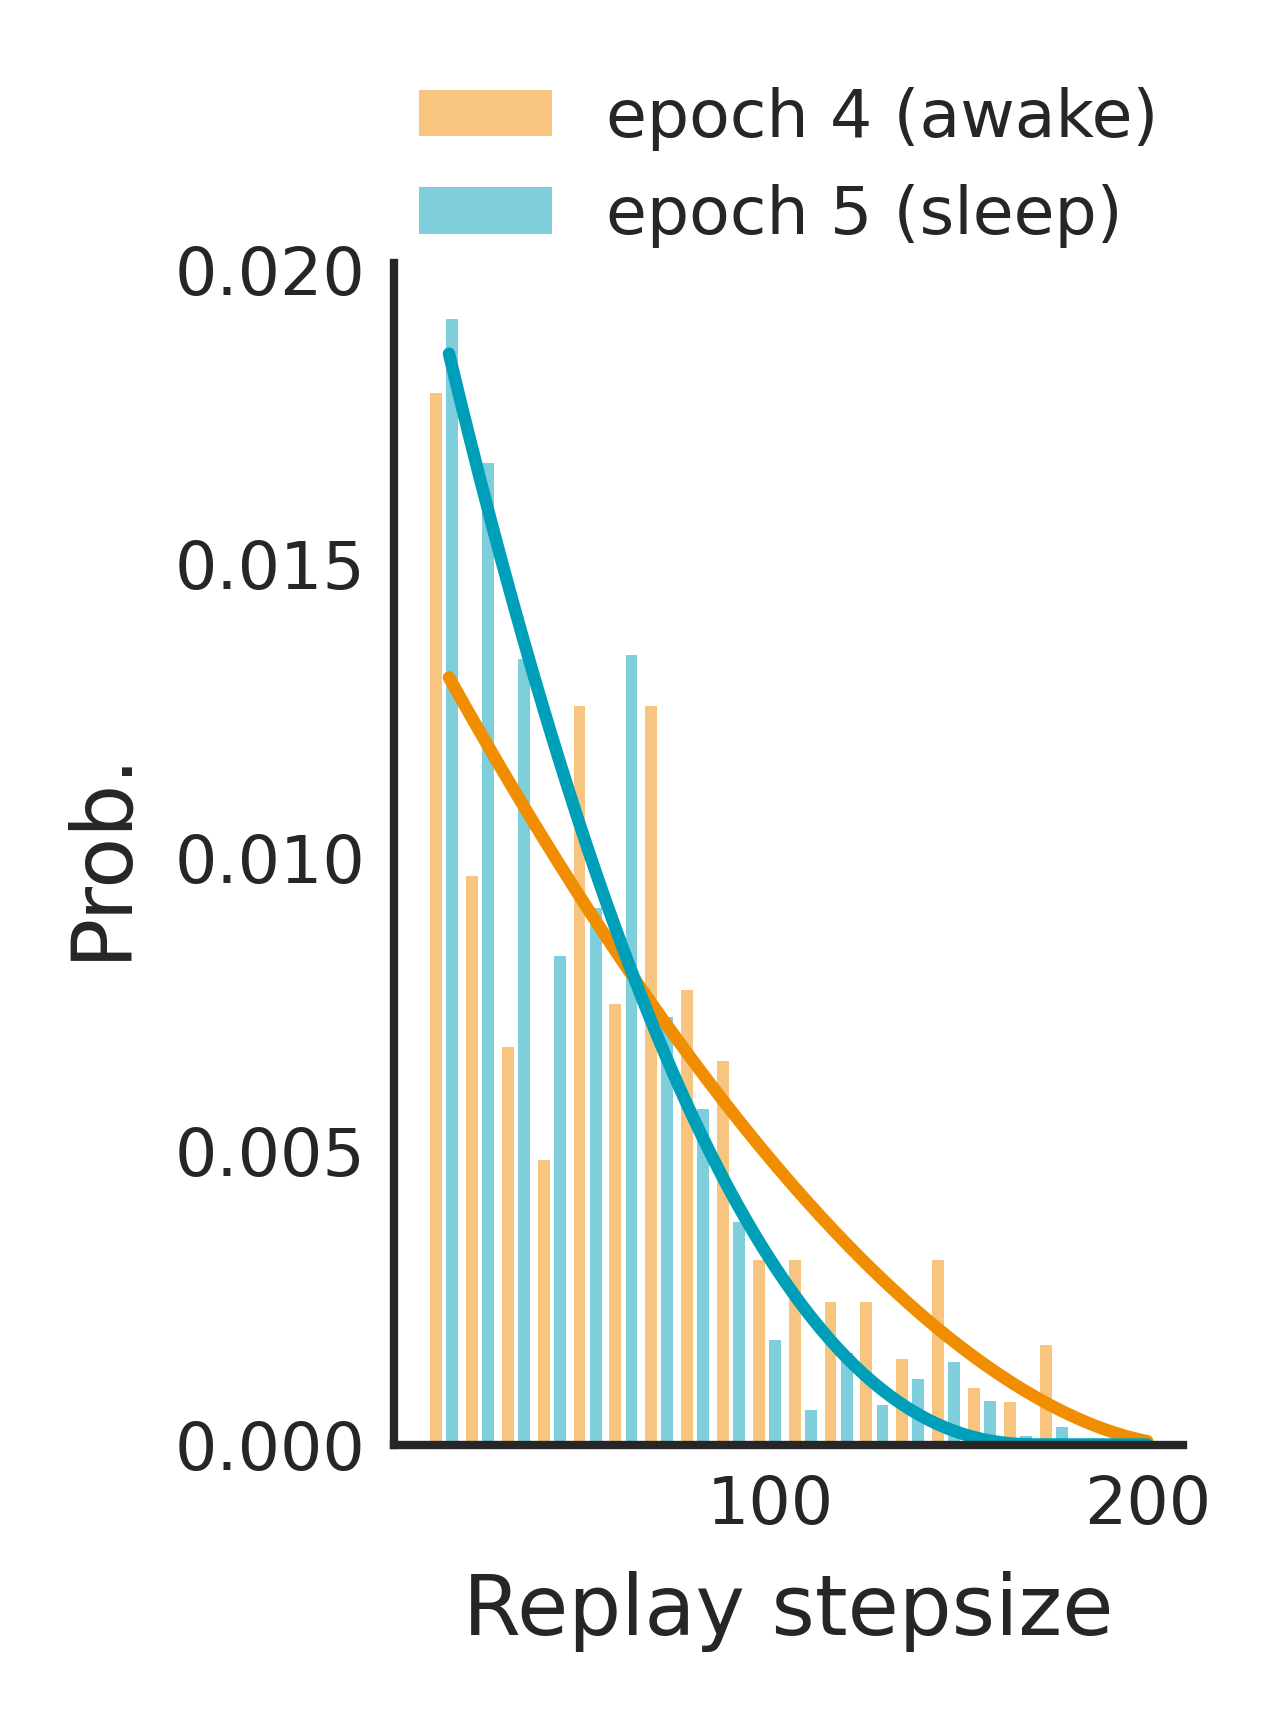

In [9]:
# awake replay
datafolder = "/media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis"
awake_epoch = ("bon", 8, 4)
with open(
    os.path.join(
        datafolder,
        "ReplayTrajectories",
        f"{awake_epoch[0]}_{awake_epoch[1]:02d}_{awake_epoch[2]:02d}_traj.pkl",
    ),
    "rb",
) as f:
    Replay_traj_awake = pickle.load(f)
awake_stepsizes = get_steps(Replay_traj_awake, timeb=1)

# sleep replay
sleep_epoch = ("bon", 8, 5)
with open(
    os.path.join(
        datafolder,
        "TrueSleepReplayTrajectories",
        f"{sleep_epoch[0]}_{sleep_epoch[1]:02d}_{sleep_epoch[2]:02d}_traj.pkl",
    ),
    "rb",
) as f:
    Replay_traj_sleep = pickle.load(f)
sleep_stepsizes = get_steps(Replay_traj_sleep, timeb=1)

# plot replay stepsize in one plot
fig, ax = plt.subplots(1, 1, figsize=(2.5, 3.3), dpi=300)
labelsize = 10
ticksize = 8


start = 10
end = 200

# remove len <5 and >100
awake_stepsizes = awake_stepsizes[(awake_stepsizes > start) & (awake_stepsizes < end)]
sleep_stepsizes = sleep_stepsizes[(sleep_stepsizes > start) & (sleep_stepsizes < end)]


# plot the hist in a normalized way
bins = np.linspace(start, end, 21)
width = (bins[1] - bins[0]) / 3

# Define the function to estimate using the GPD
# The GPD can be parameterized with location (c), scale (scale), and shape (k) parameters.
def gen_pareto_pdf(x, c, scale, k):
    return genpareto.pdf(x, c, loc=scale, scale=k)


# Calculate histogram data
hist_awake, bin_edges_awake = np.histogram(awake_stepsizes, bins=bins, density=True)
hist_sleep, bin_edges_sleep = np.histogram(sleep_stepsizes, bins=bins, density=True)

# Compute bin centers
bin_centers_awake = (bin_edges_awake[:-1] + bin_edges_awake[1:]) / 2
bin_centers_sleep = (bin_edges_sleep[:-1] + bin_edges_sleep[1:]) / 2

# Fit the GPD to the 'awake' histogram data
params_awake, _ = curve_fit(
    gen_pareto_pdf, bin_centers_awake, hist_awake, p0=[10, 10, 0.1]
)

# Fit the GPD to the 'sleep' histogram data
params_sleep, _ = curve_fit(
    gen_pareto_pdf, bin_centers_sleep, hist_sleep, p0=[10, 10, 0.1]
)

print(params_awake, params_sleep)
# Generate the x values for plotting the fitted distribution
x_values = np.linspace(start + 5, end, 400)

# Calculate the fitted GPD values
fitted_pdf_awake = gen_pareto_pdf(x_values, *params_awake)
fitted_pdf_sleep = gen_pareto_pdf(x_values, *params_sleep)


# plot the hist in a normalized way
ax.hist(
    awake_stepsizes,
    bins=bins,
    color="#F18D00",
    alpha=0.5,
    width=width,
    label="epoch 4 (awake)",
    density=True,
    align="mid",
    edgecolor="none",
)
ax.hist(
    sleep_stepsizes,
    bins=bins,
    color="#009FB9",
    alpha=0.5,
    width=width,
    label="epoch 5 (sleep)",
    density=True,
    align="mid",
    rwidth=0.1,
    edgecolor="none",
)

# plot the fitted power-law distributions
ax.plot(x_values, fitted_pdf_awake, lw=1.5, color="#F18D00")
ax.plot(x_values, fitted_pdf_sleep, lw=1.5, color="#009FB9")
# ax.set_title("rat 1 day 8", fontsize=labelsize)
ax.set_xlabel("Replay stepsize", fontsize=labelsize)
ax.legend(
    fontsize=ticksize, frameon=False, bbox_to_anchor=(0.5, 1.2), loc="upper center"
)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(1.0)
ax.spines["bottom"].set_linewidth(1.0)

ax.tick_params(axis="both", which="major", labelsize=ticksize)
ax.set_ylabel("Prob.", fontsize=labelsize)
# remove the tick bars
ax.tick_params(axis="y", length=0)
ax.tick_params(axis="x", length=0)

plt.tight_layout()

# save the figure
savedir = "/home/zilong/Desktop/AdaptiveAttractorForSequences/Figures/"
savename = "Fig6_awake_vs_sleep_histgram.pdf"

plt.savefig(savedir + savename, dpi=300, bbox_inches="tight")

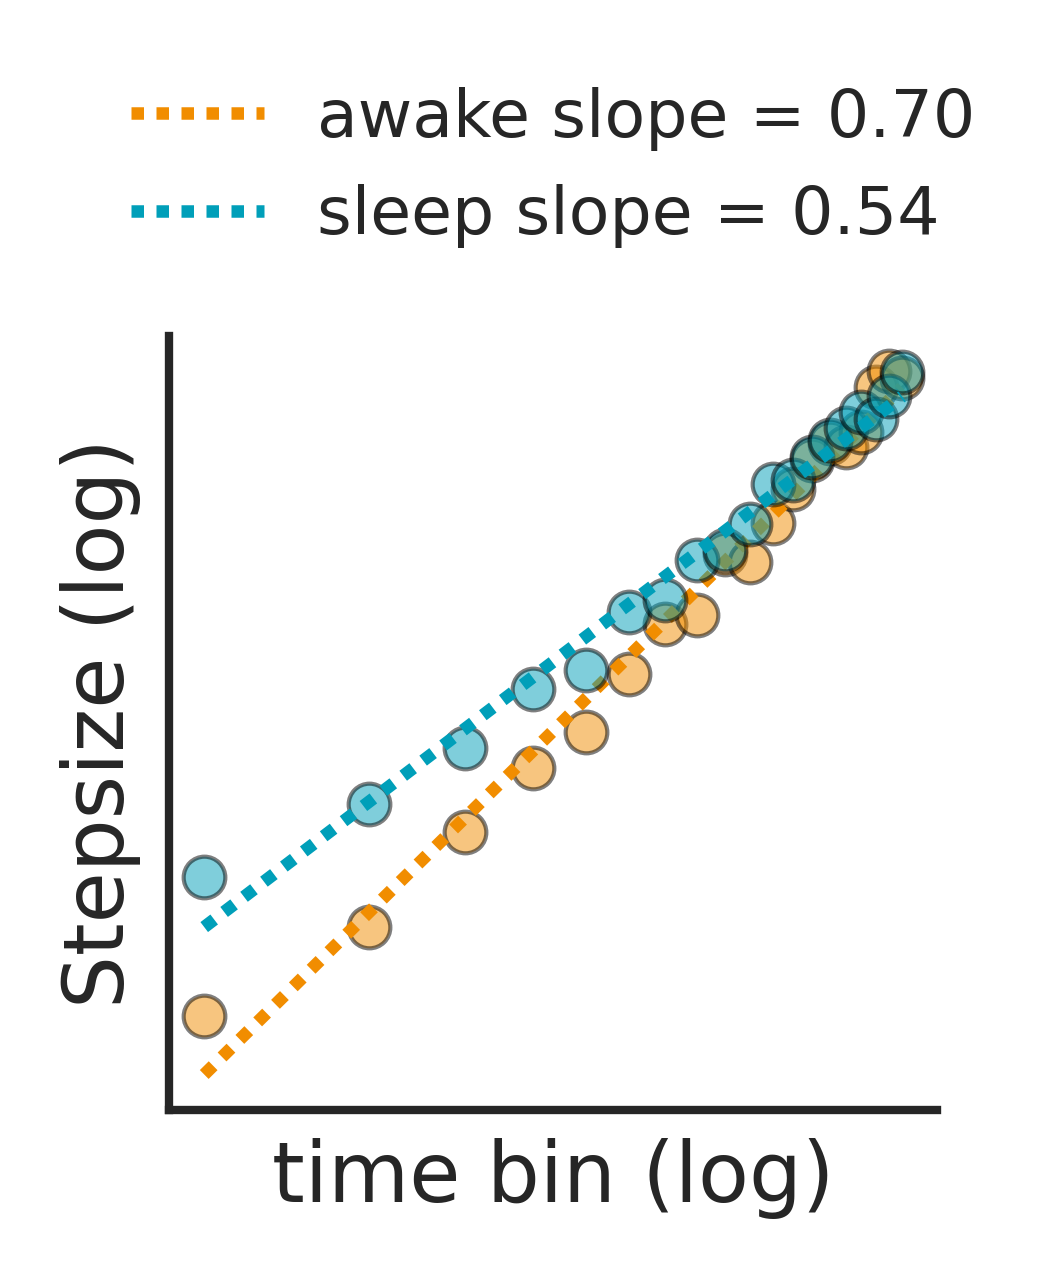

In [10]:
all_timebins = np.arange(1, 20, 1)
all_avg_steps_awake = []
all_avg_steps_sleep = []
for timeb in all_timebins:
    all_steps_awake = get_steps(Replay_traj_awake, timeb)
    # get the average step size for each time bin
    all_avg_steps_awake.append(np.mean(all_steps_awake))

    all_steps_sleep = get_steps(Replay_traj_sleep, timeb)
    # get the average step size for each time bin
    all_avg_steps_sleep.append(np.mean(all_steps_sleep))


# get the slope of the log-log plot
slope_awake, intercept_awake = np.polyfit(
    np.log(all_timebins), np.log(all_avg_steps_awake), 1
)

slope_sleep, intercept_sleep = np.polyfit(
    np.log(all_timebins), np.log(all_avg_steps_sleep), 1
)

##############################################################################
# backgrou white
fig, ax = plt.subplots(1, 1, figsize=(2, 2.8), dpi=300, facecolor="white")
labelsize = 10
ticksize = 8

# plot the log-log plot and add the slope as a lagend
# marker edge color set as black with alpha 1.0
ax.plot(
    all_timebins,
    all_avg_steps_awake,
    "o",
    color="#F18D00",
    markersize=5,
    alpha=0.5,
    markeredgecolor="black",
    markeredgewidth=0.5,
)
# add linear regression line
ax.plot(
    all_timebins,
    np.exp(intercept_awake) * all_timebins**slope_awake,
    color="#F18D00",
    linestyle=(0, (1, 1)),
    linewidth=1.5,
    label="awake slope = %.2f" % slope_awake,
)

# sleep
ax.plot(
    all_timebins,
    all_avg_steps_sleep,
    "o",
    color="#009FB9",
    markersize=5,
    alpha=0.5,
    markeredgecolor="black",
    markeredgewidth=0.5,
)

# add linear regression line
ax.plot(
    all_timebins,
    np.exp(intercept_sleep) * all_timebins**slope_sleep,
    color="#009FB9",
    linestyle=(0, (1, 1)),
    linewidth=1.5,
    label="sleep slope = %.2f" % slope_sleep,
)

ax.legend(
    fontsize=ticksize, frameon=False, bbox_to_anchor=(0.5, 1.4), loc="upper center"
)

# text of "slope = %.2f" % slope,
# ax.set_title("slope = %.2f" % slope_awake, fontsize=ticksize)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("time bin (log)", fontsize=labelsize, labelpad=0)
ax.set_ylabel("Stepsize (log)", fontsize=labelsize, labelpad=0)  # remov eticks
ax.set_xticks([])
ax.set_yticks([])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(1.0)
ax.spines["bottom"].set_linewidth(1.0)
# Explicitly remove tick marks
ax.tick_params(axis="both", which="major", length=0)
ax.tick_params(axis="both", which="minor", length=0)

plt.tight_layout()
# save the figure
savedir = "/home/zilong/Desktop/AdaptiveAttractorForSequences/Figures/"
savename = "Fig6_awake_vs_sleep_loglog.pdf"
plt.savefig(savedir + savename, dpi=300, bbox_inches="tight")

## Section 3: detect sleep period

In [11]:
from src.load_data import load_sleep_data
import matplotlib.pyplot as plt
import numpy as np
from utils import (
    get_theta2alpha_ratio,
    find_sleep_intervals,
    find_REM_interval,
    find_SIA_intervals,
    find_ones_intervals,
)
import pandas as pd
from scipy.ndimage import gaussian_filter
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
import matplotlib.gridspec as gridspec

In [12]:
# load data
epoch_key = ("bon", 8, 3)
brain_areas = ["CA1", "CA2", "CA3"]
exclude_interneuron_spikes = True
sleepdata = load_sleep_data(
    epoch_key,
    brain_areas=brain_areas,
    exclude_interneuron_spikes=exclude_interneuron_spikes,
)

In [13]:
lowspeed_thres = 4
lowspeed_duration = (60,)
theta2alpha_thres = 1.5
REM_duration = (10,)
sleep_duration = 90
LIA_duration = 5

############################################################################################################
# 1, get candidate sleep periods with speed < 4 cm/s, preceded by 60 s with no movement > 4 cm/s.
print("Get candidate sleep periods by thresholding speed...")
speed = sleepdata["position_info"].speed
is_lowspeed, lowspeed_durations, lowspeed_intervals = find_sleep_intervals(
    speed, sleep_duration_threshold=lowspeed_duration, lowspeed_threshold=lowspeed_thres
)

############################################################################################################
# 2, get REM sleep periods with the averaged theta/alpha ratio > theta2alpha_ratio using only CA1 tetrodes
print(
    "Get REM sleep periods from all CA1 tetrodes signal by thresholding theta/alpha ratio..."
)
lfps = sleepdata["lfps"]

tetrode_info = sleepdata["tetrode_info"]
is_CA1_areas = tetrode_info.area.astype(str).str.upper().isin(["CA1"])
# find lfps in CA1 according to ishilberthilbert_brain_areas
CA1_lfps = lfps.loc[:, is_CA1_areas.values]

# initial a panda dataframe to store the theta/alpha ratio for each interval
all_theta2alpha_ratio = pd.DataFrame(index=CA1_lfps.index)
# for each column in CA1_lfps, get the theta/alpha ratio
for i in range(CA1_lfps.shape[1]):
    CA1_lfp = CA1_lfps.iloc[:, i]
    # get the theta/alpha ratio
    theta2alpha_ratio = get_theta2alpha_ratio(
        CA1_lfp, thetaband=[5, 11], alphaband=[1, 4]
    )
    # add the ratio to the theta2alpha_ratio to i column in all_theta2alpha_ratio
    all_theta2alpha_ratio[i] = theta2alpha_ratio
# get the mean ratio across all columns for each time point
mean_theta2alpha_ratio = all_theta2alpha_ratio.mean(axis=1)

# get the REM intervals
is_REM, REM_durations, REM_intervals = find_REM_interval(
    mean_theta2alpha_ratio, REMduration=REM_duration, REMthreshold=theta2alpha_thres
)

############################################################################################################
# 3, get the SIA threshod using aggregated hippocampal LFP within CA1 CA2 and CA3 tetrodes, and then find LIA periods
print("Get SIA periods from aggregated LFP signal by thresholding LFP amplitude...")
is_CA123_areas = tetrode_info.area.astype(str).str.upper().isin(["CA1", "CA2", "CA3"])
# find lfps in CA1 according to is_brain_areas
CA123_lfps = lfps.loc[:, is_CA123_areas.values]
# get the aggregated lfps
for i in range(CA123_lfps.shape[1]):
    # square the lfp signal
    CA123_lfps.iloc[:, i] = CA123_lfps.iloc[:, i] ** 2
    # Gaussian smooth the lfp signal with sigma=150, i.e. 300 ms since sampling rate is 500 Hz
    CA123_lfps.iloc[:, i] = gaussian_filter(CA123_lfps.iloc[:, i], sigma=150)
    # take square root of the lfp signal
    CA123_lfps.iloc[:, i] = np.sqrt(CA123_lfps.iloc[:, i])
    # z-score the lfp signal
    CA123_lfps.iloc[:, i] = (
        CA123_lfps.iloc[:, i] - CA123_lfps.iloc[:, i].mean()
    ) / CA123_lfps.iloc[:, i].std()
# sum the lfp over all columns
CA123_lfps_sum = CA123_lfps.sum(axis=1)
# z-score the sum lfp to get the aggregate hippocampal LFP signal
aggregate_hpc_lfp = (CA123_lfps_sum - CA123_lfps_sum.mean()) / CA123_lfps_sum.std()

# get the SIA threshold
try:
    # get the histogram of the aggregate hippocampal LFP signal
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    # Get the histogram values and bin edges
    hist_values, bin_edges, _ = ax.hist(
        aggregate_hpc_lfp, bins=100, density=True, color="k"
    )

    # fitting an bimodal distribution to the histogram
    # Define the function to fit
    def bimodal(x, mu1, sigma1, mu2, sigma2, p):
        return p * norm.pdf(x, mu1, sigma1) + (1 - p) * norm.pdf(x, mu2, sigma2)

    # Fit the data using scipy.optimize.curve_fit
    p0 = [0, 1, 0, 1, 0.5]
    params, _ = curve_fit(bimodal, bin_edges[:-1], hist_values, p0=p0)
    # Plot the fitted curve on top of the histogram
    x = np.linspace(bin_edges[0], bin_edges[-1], 1000)
    # find the local minima of the fitted curve
    local_minima = argrelextrema(bimodal(x, *params), np.less)[0]

    SIA_threshold = x[local_minima][0]

    # save the figure
    plt.savefig

    # close the figure
    plt.close(fig)
except:
    SIA_threshold = -0.67

# get the SIA intervals
is_SIA, SIA_durations, SIA_intervals = find_SIA_intervals(
    aggregate_hpc_lfp, SIA_threshold=SIA_threshold
)

############################################################################################################
# 4, get nonREM_interval from lowspeed_intervals, which equals to is_lowspeed = True and is_REM = False
print("Get nonREM periods from low speed periods and REM periods...")
is_nonREM = np.logical_and(is_lowspeed, np.logical_not(is_REM))

nonREM_int = find_ones_intervals(is_nonREM)
nonREM_intervals = []
for interval in nonREM_int:
    # store valid durations if it is more than duration seconds
    nonREM_intervals.append(
        [is_nonREM.index[interval[0]], is_nonREM.index[interval[1]]]
    )

############################################################################################################
# 5, get LIA intervals as the intervals with is_lowspeed = True and is_REM = False and is_SIA = False
print("Get LIA periods from low speed periods, REM periods and SIA periods...")
is_LIA = np.logical_and(is_lowspeed, np.logical_not(is_REM))
is_LIA = np.logical_and(is_LIA, np.logical_not(is_SIA))

LIA_int = find_ones_intervals(is_LIA)
LIA_intervals = []
LIA_durations = []
for interval in LIA_int:
    # store valid durations if it is more than duration seconds
    LIA_intervals.append([is_LIA.index[interval[0]], is_LIA.index[interval[1]]])
    LIA_duration = (
        is_LIA.index[interval[1]] - is_LIA.index[interval[0]]
    ) / np.timedelta64(1, "s")
    LIA_durations.append(LIA_duration)

############################################################################################################
# 6, get the final sleep intervals
print("Get the final sleep periods from nonREM periods and LIA periods...")
# for each nonREM_interval, if inside the interval, the length of LIA interval is more than 5 seconds, then keep this REM interval
# otherwise, set is_sleep_flags to False for that interval

# copy is_nonREM to is_sleep_flags
is_sleep_flags = is_nonREM.copy()
for nonREM_interval in nonREM_intervals:

    nonREM_duration = (nonREM_interval[1] - nonREM_interval[0]) / np.timedelta64(1, "s")

    if nonREM_duration < sleep_duration:
        # set is_sleep_flags to False for that interval
        is_sleep_flags.loc[nonREM_interval[0] : nonREM_interval[1]] = False
    else:
        # check if LIA duration is more than 5 seconds in this nonREM interval
        flag = False
        for LIA_interval in LIA_intervals:
            duration = (LIA_interval[1] - LIA_interval[0]) / np.timedelta64(1, "s")
            # if the LIA interval is within any of the nonREM_intervals and the duration is more than 5 seconds, then keep it
            if (
                (LIA_interval[0] >= nonREM_interval[0])
                and (LIA_interval[1] <= nonREM_interval[1])
                and (duration > LIA_duration)
            ):
                flag = True
                break
        if flag == False:
            # set is_sleep_flags to False for that interval
            is_sleep_flags.loc[nonREM_interval[0] : nonREM_interval[1]] = False

# get the sleep intervals
sleep_int = find_ones_intervals(is_sleep_flags)
sleep_intervals = []
sleep_durations = []
for interval in sleep_int:
    # store valid durations if it is more than duration seconds
    sleep_intervals.append(
        [is_sleep_flags.index[interval[0]], is_sleep_flags.index[interval[1]]]
    )
    sleep_duration = (
        is_sleep_flags.index[interval[1]] - is_sleep_flags.index[interval[0]]
    ) / np.timedelta64(1, "s")
    sleep_durations.append(sleep_duration)

Get candidate sleep periods by thresholding speed...
Get REM sleep periods from all CA1 tetrodes signal by thresholding theta/alpha ratio...
Get SIA periods from aggregated LFP signal by thresholding LFP amplitude...
Get nonREM periods from low speed periods and REM periods...
Get LIA periods from low speed periods, REM periods and SIA periods...
Get the final sleep periods from nonREM periods and LIA periods...


Plot the results...


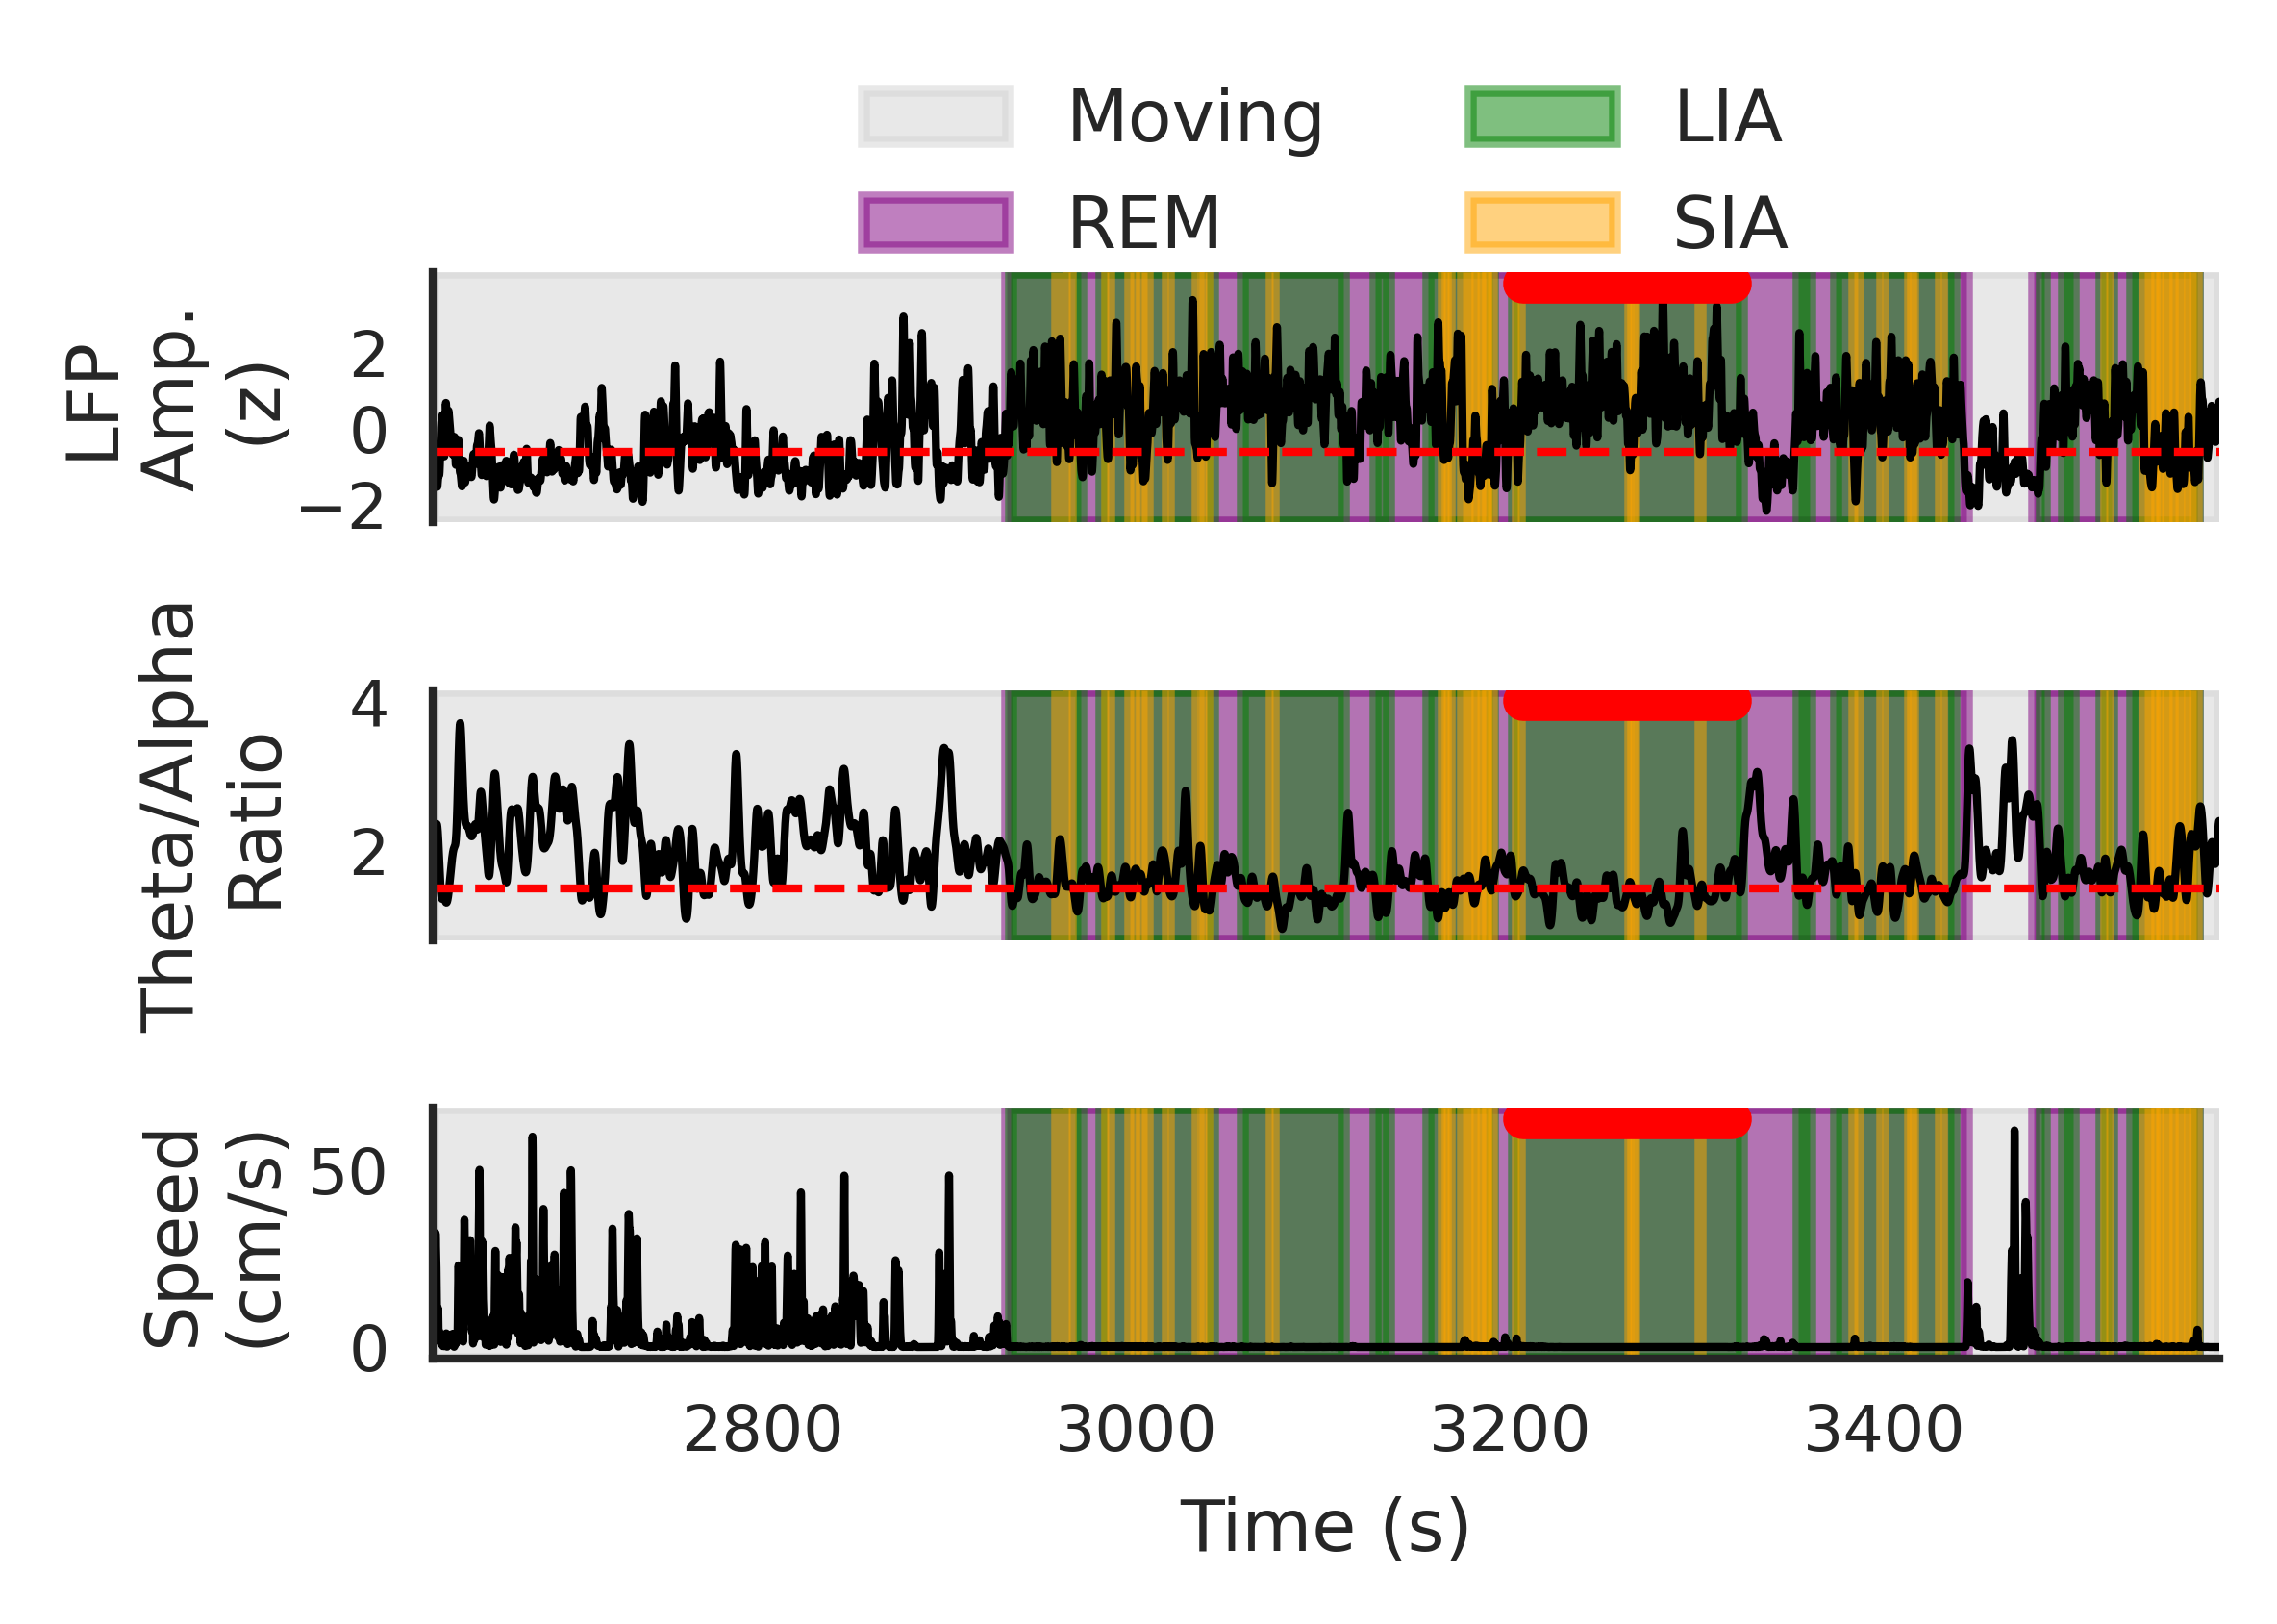

In [14]:
############################################################################################################
# 7, plot the results
print("Plot the results...")
fig = plt.figure(figsize=(4.3, 3.5), dpi=300, facecolor="white")

# make subplots height as 1:1:1:3
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])

# set label font size
labelsize = 9
# set tick font size
ticksize = 8

# 1, plot the aggregate hippocampal LFP signal
ax0 = plt.subplot(gs[0, 0])
ax0.plot(
    aggregate_hpc_lfp.index / np.timedelta64(1, "s"),
    aggregate_hpc_lfp,
    "k",
    alpha=1,
    linewidth=1,
)
# add SIAThreshold as a horizontal line
ax0.axhline(
    y=SIA_threshold, color="r", linestyle="--", linewidth=1, label="SIA threshold"
)

ax0.set_ylabel("LFP\nAmp.\n(z)", fontsize=labelsize)
ax0.set_xticks([])
ax0.set_yticks([-2, 0, 2])
ax0.spines["bottom"].set_visible(False)

# 2, plot the theta/alpha ratio
ax1 = plt.subplot(gs[1, 0])
ax1.plot(
    mean_theta2alpha_ratio.index / np.timedelta64(1, "s"),
    mean_theta2alpha_ratio,
    "k",
    alpha=1,
    linewidth=1,
)
ax1.set_ylabel("Theta/Alpha\nRatio", fontsize=labelsize)
# add REMthreshold as a horizontal line
ax1.axhline(
    y=theta2alpha_thres, color="r", linestyle="--", linewidth=1, label="REM threshold"
)

ax1.set_xticks([])
ax1.set_yticks([0, 2, 4])
ax1.spines["bottom"].set_visible(False)

# 3, plot the speed
ax2 = plt.subplot(gs[2, 0])
ax2.plot(speed.index / np.timedelta64(1, "s"), speed, "k", alpha=1, linewidth=1)
ax2.set_xlabel("Time (s)", fontsize=labelsize)
ax2.set_ylabel("Speed\n(cm/s)", fontsize=labelsize)

# 4 add shaded area for different sleep stages to all
times = aggregate_hpc_lfp.index / np.timedelta64(1, "s")
for ax in [ax0, ax1, ax2]:
    ax.set_xlim([times[0], times[-1]])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    # center align y label vertical
    ax.yaxis.set_label_coords(-0.08, 0.5)
    # axis line width 1.0
    ax.spines["bottom"].set_linewidth(1.0)
    ax.spines["left"].set_linewidth(1.0)
    # set axes tick width
    ax.tick_params(axis="both", which="both", length=2, width=1.0)

    ax.tick_params(labelsize=ticksize)

    # a, background color
    ax.axvspan(times[0], times[-1], alpha=0.5, color="lightgrey", label="Moving")

    # b, lowspeed sleep candidate as purple
    for i in range(len(lowspeed_intervals)):
        ax.axvspan(
            lowspeed_intervals[i][0] / np.timedelta64(1, "s"),
            lowspeed_intervals[i][1] / np.timedelta64(1, "s"),
            alpha=0.5,
            color="purple",
            label="REM",
        )

    # c, nonREM intervals as green
    for i in range(len(nonREM_intervals)):
        ax.axvspan(
            nonREM_intervals[i][0] / np.timedelta64(1, "s"),
            nonREM_intervals[i][1] / np.timedelta64(1, "s"),
            alpha=0.5,
            color="green",
            label="LIA",
        )

    # d, SIA intervals as orange
    for i in range(len(SIA_intervals)):
        SIA_interval = SIA_intervals[i]
        # if the SIA interval is within any of the nonREM_intervals, the plot it as orange
        for j in range(len(nonREM_intervals)):
            nonREM_interval = nonREM_intervals[j]
            if (SIA_interval[0] >= nonREM_interval[0]) and (
                SIA_interval[1] <= nonREM_interval[1]
            ):
                ax.axvspan(
                    SIA_interval[0] / np.timedelta64(1, "s"),
                    SIA_interval[1] / np.timedelta64(1, "s"),
                    alpha=0.5,
                    color="orange",
                    label="SIA",
                )
                break

# show the legend but without repeating the labels, put the legend outside the plot on the right side
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# put legend in multiple columns at the bottom of the plot, belwo xlabel
ax0.legend(
    by_label.values(),
    by_label.keys(),
    loc="upper center",
    bbox_to_anchor=(0.5, 2.0),
    frameon=False,
    fontsize=labelsize,
    ncol=2,
)

# e, add sleep_interval as thin black bars above axvspan (not overlapping with axvspan) at 1.1*ylim upper limit to the first plot
# get y lim for the first plot
for i in range(len(sleep_intervals)):
    sleep_interval = sleep_intervals[i]
    y_upperlim = ax0.get_ylim()[1]
    ax0.plot(
        [
            sleep_interval[0] / np.timedelta64(1, "s") + 5,
            sleep_interval[1] / np.timedelta64(1, "s") - 5,
        ],
        [y_upperlim, y_upperlim],
        "r",
        alpha=1,
        linewidth=5,
    )

    y_upperlim = ax1.get_ylim()[1]
    ax1.plot(
        [
            sleep_interval[0] / np.timedelta64(1, "s") + 5,
            sleep_interval[1] / np.timedelta64(1, "s") - 5,
        ],
        [y_upperlim, y_upperlim],
        "r",
        alpha=1,
        linewidth=5,
    )

    y_upperlim = ax2.get_ylim()[1]
    ax2.plot(
        [
            sleep_interval[0] / np.timedelta64(1, "s") + 5,
            sleep_interval[1] / np.timedelta64(1, "s") - 5,
        ],
        [y_upperlim, y_upperlim],
        "r",
        alpha=1,
        linewidth=5,
    )


plt.tight_layout()

# save the figure
animal, day, epoch = epoch_key

savedir = "/home/zilong/Desktop/AdaptiveAttractorForSequences/Figures/"
savename = f"Fig6_awake_vs_sleep_sleep_stages_{animal}_{day}_{epoch}.pdf"

plt.savefig(savedir + savename, dpi=300, bbox_inches="tight")

## Section 4: plot the diffusivity for all epochs, each for one epoch

In [15]:
# geneerate shuffled replay trajectories by shuffle the value under the key 'replay_trajectory'
def position_shuffling(Replay_traj):
    """
    shuffle the replay trajectory by shuffling the decoded position under each key of Replay_traj
    Input:
        Replay_traj: the replay trajectory
    Output:
        Replay_traj_shuffled: the shuffled replay trajectory
    """
    Replay_traj_shuffled = Replay_traj.copy()
    for key in Replay_traj_shuffled.keys():
        Replay_traj_shuffled[key] = np.random.permutation(Replay_traj_shuffled[key])
    return Replay_traj_shuffled

In [16]:
# load all replay trajectory from computer
replay_folder = (
    "/home/zilong/Desktop/AdaptiveAttractorForSequences/ExpData/ReplayTrajectories"
)

# get all file with _traj.pkl
replay_files = [f for f in os.listdir(replay_folder) if f.endswith("_traj.pkl")]

# for each file, load the replay trajectory
all_exponent = []
all_exponent_shuffled = []
for replay_file in replay_files:
    # print("loading file: and calculate the diffusion exponent")
    print("load file: ", replay_file, " and calculate the diffusion exponent")
    with open(os.path.join(replay_folder, replay_file), "rb") as f:
        Replay_traj = pickle.load(f)
        exponent = get_diffusion_exponent(Replay_traj)
        all_exponent.append(exponent)

        # shuflle the replay trajectory
        Replay_traj_shuffled = position_shuffling(Replay_traj)
        exponent_shuffled = get_diffusion_exponent(Replay_traj_shuffled)
        all_exponent_shuffled.append(exponent_shuffled)

load file:  dav_07_07_traj.pkl  and calculate the diffusion exponent
load file:  bon_07_06_traj.pkl  and calculate the diffusion exponent
load file:  Cor_02_02_traj.pkl  and calculate the diffusion exponent
load file:  bon_07_02_traj.pkl  and calculate the diffusion exponent
load file:  bon_05_06_traj.pkl  and calculate the diffusion exponent
load file:  gov_08_04_traj.pkl  and calculate the diffusion exponent
load file:  dud_06_02_traj.pkl  and calculate the diffusion exponent
load file:  bon_03_02_traj.pkl  and calculate the diffusion exponent
load file:  Cor_07_02_traj.pkl  and calculate the diffusion exponent
load file:  dav_07_03_traj.pkl  and calculate the diffusion exponent
load file:  fra_04_02_traj.pkl  and calculate the diffusion exponent
load file:  gov_10_02_traj.pkl  and calculate the diffusion exponent
load file:  con_01_04_traj.pkl  and calculate the diffusion exponent
load file:  dav_04_02_traj.pkl  and calculate the diffusion exponent
load file:  con_03_02_traj.pkl  an

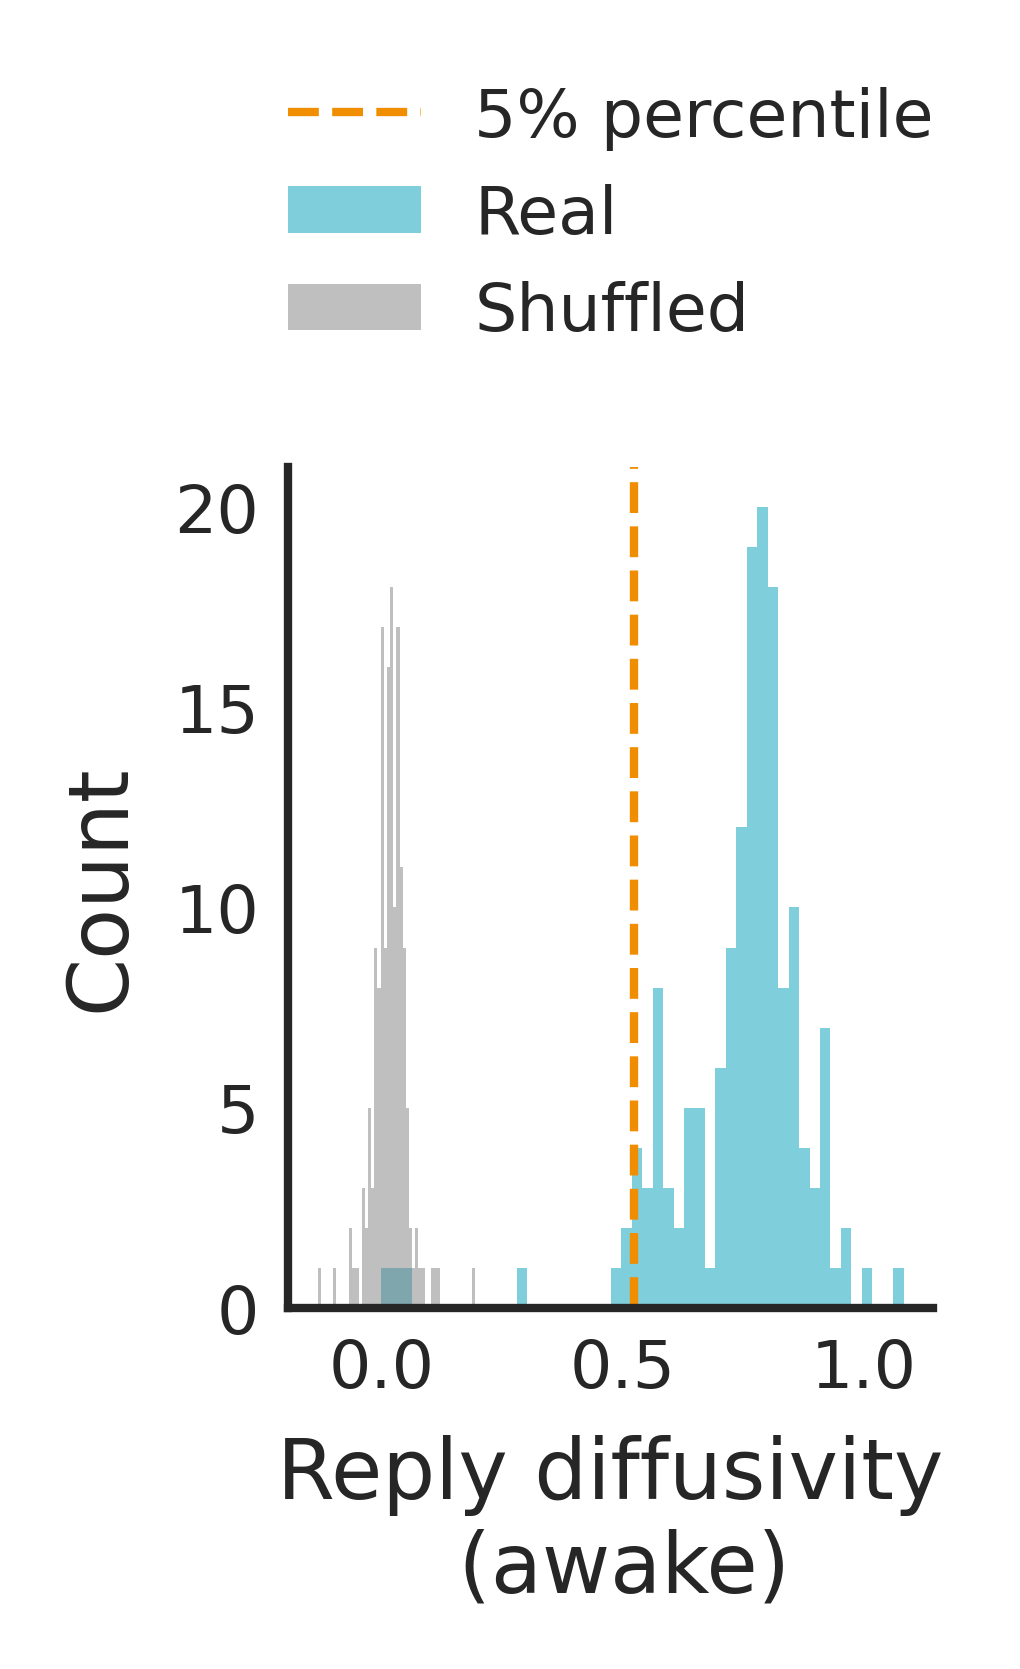

In [17]:
# load replay trajectory from the 'ReplayTrajectories'
animal, day, epoch = ("bon", 8, 4)
with open(
    os.path.join(replay_folder, f"{animal}_{day:02d}_{epoch:02d}_traj.pkl"), "rb"
) as f:
    Replay_traj = pickle.load(f)

all_timebins = np.arange(1, 20, 1)
all_avg_steps = []
for timeb in all_timebins:
    all_steps = get_steps(Replay_traj, timeb)
    # get the average step size for each time bin
    avg_step = np.mean(all_steps)
    all_avg_steps.append(avg_step)

# get the slope of the log-log plot
slope, intercept = np.polyfit(np.log(all_timebins), np.log(all_avg_steps), 1)

# get shuffled replay trajectory
Replay_traj_shuffled = position_shuffling(Replay_traj)
all_avg_steps_shuffled = []
for timeb in all_timebins:
    all_steps = get_steps(Replay_traj_shuffled, timeb)
    # get the average step size for each time bin
    avg_step = np.mean(all_steps)
    all_avg_steps_shuffled.append(avg_step)

# get the slope of the log-log plot
slope_shuffled, intercept_shuffled = np.polyfit(
    np.log(all_timebins), np.log(all_avg_steps_shuffled), 1
)


fig = plt.figure(figsize=(2.1, 3.5), dpi=300)
gs = gridspec.GridSpec(1, 1)
labelsize = 10
ticksize = 8
realtraj_color = "#009FB9"

# ax 2
ax2 = plt.subplot(gs[0])

# plot the distribution of all_exponent and all_exponent_shuffled
ax2.hist(
    all_exponent,
    bins=50,
    color=realtraj_color,
    alpha=0.5,
    edgecolor="none",
    label="Real",
)
ax2.hist(
    all_exponent_shuffled,
    bins=50,
    color="grey",
    alpha=0.5,
    edgecolor="none",
    label="Shuffled",
)

# mark the 5% percentile of the all_exponent as a black dashed line
ax2.axvline(
    np.percentile(all_exponent, 5),
    color="#F18D00",
    linestyle="--",
    label="5% percentile",
    linewidth=1,
)
# legend
ax2.legend(fontsize=ticksize, frameon=False, loc="center", bbox_to_anchor=(0.5, 1.3))

# xlabel and ylabel
ax2.set_xlabel("Reply diffusivity\n (awake)", fontsize=labelsize)
ax2.set_ylabel("Count", fontsize=labelsize)

# for all axes, set upper and right spine off, axis line width 1.0
all_axes = fig.get_axes()
for ax in all_axes:
    ax.tick_params(labelsize=ticksize)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # axis line width 1.0
    ax.spines["bottom"].set_linewidth(1.0)
    ax.spines["left"].set_linewidth(1.0)
    # remove the tick bars on the left and bottom
    ax.tick_params(axis="both", which="both", length=0)

plt.tight_layout()

# save the figure to /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/
savedir = "/home/zilong/Desktop/AdaptiveAttractorForSequences/Figures/"

savename = "Fig6_awake_vs_sleep_allawake_exponents.pdf"
plt.savefig(savedir + savename, dpi=300, bbox_inches="tight")

In [18]:
# do a one sample ttest to see if all_exponent is different from 0.5, and print t and p
from scipy.stats import ttest_1samp

t, p = ttest_1samp(all_exponent, 0.5)
print("t = ", t, "p = ", p)
print(len(all_exponent))

t =  19.992997643212853 p =  3.983083735937138e-45
159


In [19]:
# using wilcoxon signed rank test to see if all_exponent is different from 0.5, and print p
from scipy.stats import wilcoxon

w, p = wilcoxon(np.asarray(all_exponent) - 0.5)

print("w = ", w, "p = ", p)

w =  508.0 p =  7.996722715105623e-24


## Section 5: compare the diffusion exponent between awake replay and sleep replay

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm.auto import tqdm

from loren_frank_data_processing import make_epochs_dataframe, make_neuron_dataframe
from src.parameters import ANIMALS, MIN_N_NEURONS, _BRAIN_AREAS
from src.load_data import get_sleep_and_prev_run_epochs
from utils import get_diffusion_exponent

In [21]:
epoch_info = make_epochs_dataframe(ANIMALS)
neuron_info = make_neuron_dataframe(ANIMALS)

neuron_info = neuron_info.loc[
    (neuron_info.type == "principal")
    & (neuron_info.numspikes > 100)
    & neuron_info.area.isin(_BRAIN_AREAS)
]

n_neurons = (
    neuron_info.groupby(["animal", "day", "epoch"])
    .neuron_id.agg(len)
    .rename("n_neurons")
    .to_frame()
)

epoch_info = epoch_info.join(n_neurons)

# select only sleep epochs
is_sleep = epoch_info.type.isin(["sleep"])

is_animal = epoch_info.index.isin(
    ["bon", "fra", "gov", "dud", "con", "dav", "Cor", "egy", "cha"], level="animal"
)

# get valid epochs with is_sleep and is_animal and n_neurons > MIN_N_NEURONS
valid_epochs = epoch_info.loc[
    is_sleep & is_animal & (epoch_info.n_neurons > MIN_N_NEURONS)
]

sleep_epoch_keys, prev_run_epoch_keys = get_sleep_and_prev_run_epochs()

# get valid sleep epochs with keys only in sleep_epoch_keys
valid_sleep_epochs = valid_epochs.loc[valid_epochs.index.isin(sleep_epoch_keys)]

PROCESSED_DATA_DIR = "/media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis"

In [22]:
SleepEXP = []
SleepIntcp = []
RunEXP = []
RunIntcp = []

replay_num = []

for sleep_epoch_key in tqdm(valid_sleep_epochs.index, desc="epochs"):
    # current sleep epoch
    animal_sleep, day_sleep, epoch_sleep = sleep_epoch_key

    # get previous run epoch
    prev_run_epoch_key = prev_run_epoch_keys[sleep_epoch_keys.index(sleep_epoch_key)]
    animal_run, day_run, epoch_run = prev_run_epoch_key

    # for each sleep_epoch_key
    sleep_result = os.path.join(
        PROCESSED_DATA_DIR,
        "TrueSleepReplayTrajectories",
        (f"{animal_sleep}_{day_sleep:02d}_{epoch_sleep:02d}_traj.pkl"),
    )

    run_result = os.path.join(
        PROCESSED_DATA_DIR,
        "ReplayTrajectories",
        (f"{animal_run}_{day_run:02d}_{epoch_run:02d}_traj.pkl"),
    )

    # check if the file exists, if does, then extract the data
    if os.path.exists(sleep_result) and os.path.exists(run_result):

        print("Loading %s" % sleep_result)
        with open(sleep_result, "rb") as f:
            Sleep_Replay_traj = pickle.load(f)

        replay_num.append(len(Sleep_Replay_traj))
        # extract previous run epoch results

        print("Loading %s" % run_result)
        with open(run_result, "rb") as f:
            Run_Replay_traj = pickle.load(f)

        # get exponent for sleep epoch
        sleep_exponent, sleep_intercept = get_diffusion_exponent(
            Sleep_Replay_traj, get_intercept=True
        )
        SleepEXP.append(sleep_exponent)
        SleepIntcp.append(sleep_intercept)

        # get exponent for run epoch
        run_exponent, run_intercept = get_diffusion_exponent(
            Run_Replay_traj, get_intercept=True
        )
        RunEXP.append(run_exponent)
        RunIntcp.append(run_intercept)

epochs:   0%|          | 0/116 [00:00<?, ?it/s]

epochs:   1%|          | 1/116 [00:00<00:17,  6.73it/s]

Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/Cor_01_05_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/Cor_01_04_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/Cor_02_03_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/Cor_02_02_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/Cor_02_05_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/Cor_02_04_traj.pkl


epochs:   5%|▌         | 6/116 [00:00<00:06, 15.95it/s]

Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/Cor_03_05_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/Cor_03_04_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/Cor_04_05_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/Cor_04_04_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/Cor_07_03_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/Cor_07_02_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/bon_03_03_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/bon_03_02_traj.pkl


epochs:  15%|█▍        | 17/116 [00:00<00:03, 27.43it/s]

Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/bon_03_05_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/bon_03_04_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/bon_03_07_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/bon_03_06_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/bon_04_05_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/bon_04_04_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/bon_04_07_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/bon_04_06_traj.pkl


epochs:  17%|█▋        | 20/116 [00:00<00:04, 22.63it/s]

Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/bon_05_03_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/bon_05_02_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/bon_05_05_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/bon_05_04_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/bon_06_03_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/bon_06_02_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/bon_06_05_traj.pkl


epochs:  20%|█▉        | 23/116 [00:01<00:03, 23.47it/s]

Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/bon_06_04_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/bon_06_07_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/bon_06_06_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/bon_07_03_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/bon_07_02_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/bon_07_05_traj.pkl


epochs:  22%|██▏       | 26/116 [00:01<00:04, 19.52it/s]

Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/bon_07_04_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/bon_07_07_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/bon_07_06_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/bon_08_03_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/bon_08_02_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/bon_08_05_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/bon_08_04_traj.pkl


epochs:  29%|██▉       | 34/116 [00:01<00:03, 23.74it/s]

Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/bon_08_07_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/bon_08_06_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/bon_10_03_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/bon_10_02_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/cha_04_03_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/cha_04_02_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/con_01_05_traj.pkl


epochs:  34%|███▍      | 40/116 [00:01<00:02, 30.19it/s]

Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/con_01_04_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/con_02_03_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/con_02_02_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/con_02_05_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/con_02_04_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/con_03_03_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/con_03_02_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/con_03_05_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/con_03_04_traj.pkl


epochs:  41%|████▏     | 48/116 [00:01<00:02, 28.19it/s]

Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/con_04_07_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/con_04_06_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/con_05_03_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/con_05_02_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/con_06_03_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/con_06_02_traj.pkl


epochs:  46%|████▌     | 53/116 [00:02<00:02, 27.18it/s]

Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/con_06_07_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/con_06_06_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/dav_03_07_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/dav_03_06_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/dav_04_03_traj.pkl


epochs:  48%|████▊     | 56/116 [00:02<00:02, 24.83it/s]

Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/dav_04_02_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/dav_04_05_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/dav_04_04_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/dav_06_03_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/dav_06_02_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/dav_06_05_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/dav_06_04_traj.pkl


epochs:  53%|█████▎    | 62/116 [00:02<00:02, 19.97it/s]

Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/dav_06_07_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/dav_06_06_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/dud_02_03_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/dud_02_02_traj.pkl


epochs:  56%|█████▌    | 65/116 [00:02<00:02, 19.56it/s]

Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/dud_06_05_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/dud_06_04_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/egy_05_03_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/egy_05_02_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/egy_05_05_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/egy_05_04_traj.pkl


epochs:  59%|█████▊    | 68/116 [00:03<00:03, 15.14it/s]

Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/egy_05_07_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/egy_05_06_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/egy_08_05_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/egy_08_04_traj.pkl


epochs:  87%|████████▋ | 101/116 [00:03<00:00, 65.05it/s]

Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/fra_06_07_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/fra_06_06_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/gov_07_05_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/gov_07_04_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/gov_08_05_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/gov_08_04_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/gov_08_07_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/gov_08_06_traj.pkl


epochs:  96%|█████████▌| 111/116 [00:03<00:00, 54.68it/s]

Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/gov_09_06_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/gov_09_05_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/gov_11_05_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/gov_11_04_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/gov_12_07_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/gov_12_06_traj.pkl


epochs: 100%|██████████| 116/116 [00:03<00:00, 31.26it/s]

Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/TrueSleepReplayTrajectories/gov_13_07_traj.pkl
Loading /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/ReplayTrajectories/gov_13_06_traj.pkl


In [23]:
# print mean and std of replay_num
print("mean of replay num: ", np.mean(replay_num))
print("std of replay num: ", np.std(replay_num))

# 53 epochs in total

mean of replay num:  247.64150943396226
std of replay num:  153.98396073539396


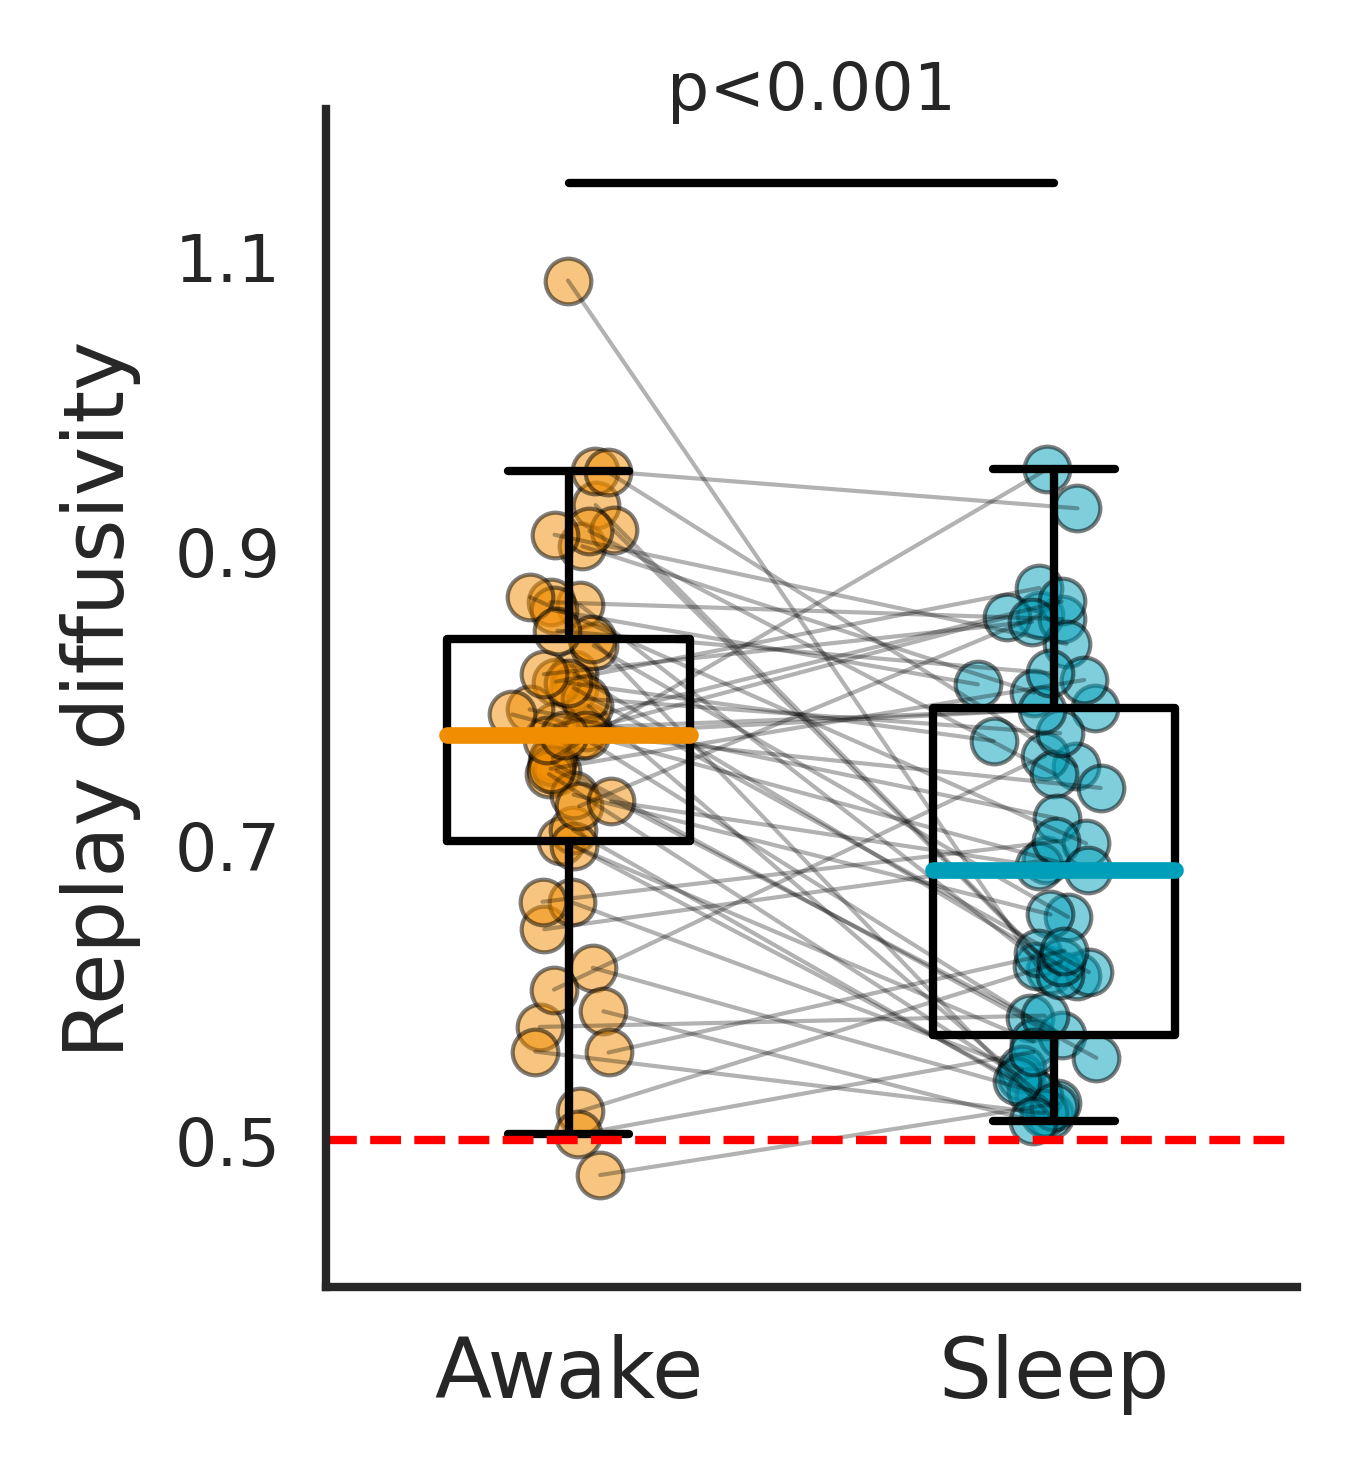

In [24]:
# barplot of SleepEXP and RunEXP in subplot 1, as well as SleepIntcp and RunIntcp in subplot 2
fig, ax = plt.subplots(1, 1, figsize=(2.6, 2.8), dpi=300)

labelsize = 10
ticksize = 8
# boxplot without mark outliers
bp = ax.boxplot([RunEXP, SleepEXP], positions=[0, 1], widths=0.5, showfliers=False)

# Set different colors for medians
for median, color in zip(bp["medians"], ["#F18D00", "#009FB9"]):
    median.set(color=color, linewidth=2)

# add scatter plot and add jitter for better visualization
RunX = np.zeros(len(RunEXP)) + np.random.normal(0, 0.05, len(RunEXP))
ax.scatter(
    RunX, RunEXP, color="#F18D00", s=30, alpha=0.5, edgecolors="black", linewidth=0.5
)
SleepX = np.ones(len(SleepEXP)) + np.random.normal(0, 0.05, len(SleepEXP))
# edgewidth = 0.5
ax.scatter(
    SleepX,
    SleepEXP,
    color="#009FB9",
    s=30,
    alpha=0.5,
    edgecolors="black",
    linewidth=0.5,
)

# link paired data with a line
for i in range(len(SleepEXP)):
    # ax.plot([0, 1], [RunEXP[i], SleepEXP[i]], color="black", alpha=0.1, linewidth=1)
    ax.plot(
        [RunX[i], SleepX[i]],
        [RunEXP[i], SleepEXP[i]],
        color="black",
        alpha=0.3,
        linewidth=0.5,
    )

# add a horizontal line at y=0.5 as red
ax.axhline(y=0.5, color="red", linestyle="--", linewidth=1)

# carry out wilcoxon test
from scipy.stats import wilcoxon

stat, p = wilcoxon(RunEXP, SleepEXP)
# stat, p = ttest_rel(SleepEXP, RunEXP)

# add horizontal line link (0,1) and (1,1)
ax.plot([0, 1], [1.15, 1.15], color="black", alpha=1, linewidth=1)
# # add horizontal line and stars above the line to indicate the p value
# if p < 0.001:
#     ax.text(0.5, 1.15, "***", fontsize=labelsize, horizontalalignment="center")
# elif p < 0.01:
#     ax.text(0.5, 1.15, "**", fontsize=labelsize, horizontalalignment="center")
# elif p < 0.05:
#     ax.text(0.5, 1.15, "*", fontsize=labelsize, horizontalalignment="center")
# else:
#     ax.text(
#         0.5,
#         1.15,
#         "n.s.",
#         fontsize=labelsize,
#         horizontalalignment="center",
#         verticalalignment="center",
#     )

# add p value above the line in scientific notation
if p < 0.001:
    ax.text(0.5, 1.2, "p<0.001", fontsize=ticksize, horizontalalignment="center")
else:
    ax.text(0.5, 1.2, "p=%.2e" % p, fontsize=ticksize, horizontalalignment="center")

# add stats and p value to the title
# ax[0].set_title('Wilcoxon test: stat=%.2f, p=%.3f'%(stat, p))
# ax.set_title("t(52)=%.2f, p=%.3f" % (stat, p), fontsize=ticksize, pad=5)
ax.set_xticks([0, 1])
ax.set_xticklabels(["Awake", "Sleep"], fontsize=labelsize)
ax.set_ylabel("Replay diffusivity", fontsize=labelsize)
ax.set_ylim([0.4, 1.2])
# yticks as 0.5, 0.6, 0.7, 0.8, 0.9, 1.0
ax.set_yticks([0.5, 0.7, 0.9, 1.1])
# set x ticksize as labelsize y ticksize as ticksize
ax.tick_params(axis="x", labelsize=labelsize)
ax.tick_params(axis="y", labelsize=ticksize)

# spines top and right off
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# axis line width 1.0
ax.spines["bottom"].set_linewidth(1.0)
ax.spines["left"].set_linewidth(1.0)
# axes tick width
ax.tick_params(axis="both", which="both", length=2, width=1.0)

plt.tight_layout()

# save the figure to /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/
savedir = "/home/zilong/Desktop/AdaptiveAttractorForSequences/Figures/"
savename = "Fig6_awake_vs_sleep_diffusivity_compare.pdf"

plt.savefig(savedir + savename, dpi=300, bbox_inches="tight")